In [73]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage,BaseMessage,AIMessage,SystemMessage
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
from typing import List,Annotated,TypedDict,Literal
from pydantic import BaseModel,Field
from dotenv import load_dotenv
import sqlite3

In [74]:
load_dotenv()

True

In [75]:

model=ChatGroq(model="llama-3.1-8b-instant")

In [76]:
class StateSchema(TypedDict):
    article:str
    tweet:str
    feedback:Annotated[list[BaseMessage],add_messages]
    score:float
    iterator:int
    

In [77]:
class ArticleSchema(BaseModel):
    tweet:Annotated[str,Field(description="5-tweet thread content")]

class TweetSchema(BaseModel):
    score:Annotated[float,Field(description="Score out of 10")]
    status:Literal["accepted","rejected"]
    feedback:Annotated[str,Field(description="Constructive feedback")]

In [78]:
model1=model.with_structured_output(ArticleSchema)
model2=model.with_structured_output(TweetSchema)

In [79]:
def tweet_generator(state:StateSchema):
    sys_instr=SystemMessage(content="You are a senior Ghostwriter.Generate a thread that must be punchy, have no corporate speak, and must be exactly 5 tweets long.")
    human_msg=HumanMessage(content=f"Summarize the article {state['article']},")
    response=model1.invoke([sys_instr,human_msg])

    return {
        "tweet":response.tweet,
        "iterator":0
    }

def tweet_evaluator(state:StateSchema):
    sys_instr=SystemMessage(content="You are a strict Evaluator. Score the tweet out of 10, reject it if it seems AI-generated or punchy")
    human_msg=HumanMessage(content=f"Tweet {state['tweet']},")

    response=model2.invoke([sys_instr,human_msg])

    return {
        "feedback":[AIMessage(content=response.feedback)],
        "score":response.score
    }

def tweet_optimizer(state:StateSchema):
    last_feedback=state["feedback"][-1].content
    sys_instr=SystemMessage(content="You are an Optimizer.Optimize the tweet given the feedback")
    human_msg=HumanMessage(content=f"Original Tweet: {state['tweet']}, Feedback: {last_feedback}")

    response=model.invoke([sys_instr,human_msg])
    iterator=state["iterator"]+1

    return {
        "tweet":response.content,
        "iterator":iterator
    }

def check_condition(state:StateSchema):

    if state["score"]>=7 or state["iterator"]>=3:
        return "approved"
    return "rejected"

In [80]:
graph=StateGraph(StateSchema)


In [81]:
conn=sqlite3.connect(database='tweet.db',check_same_thread=False)
checkpointer=SqliteSaver(conn=conn)

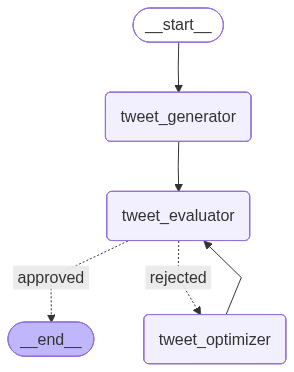

In [82]:
graph.add_node("tweet_generator",tweet_generator)
graph.add_node("tweet_evaluator",tweet_evaluator)
graph.add_node("tweet_optimizer",tweet_optimizer)

graph.add_edge(START,"tweet_generator")
graph.add_edge("tweet_generator","tweet_evaluator")
graph.add_conditional_edges("tweet_evaluator",check_condition,{"approved":END,"rejected":"tweet_optimizer"})
graph.add_edge("tweet_optimizer","tweet_evaluator")

workflow=graph.compile(checkpointer=checkpointer)
workflow

In [83]:
initial_state={
    "article":"""The U.S. economy grew at its fastest pace in two years during the third quarter of 2025, driven by robust consumer spending and a sharp rebound in exports, according to Reuters.
 However, momentum appears to have weakened amid rising living costs and the recent government shutdown.
 This economic growth comes at a time when businesses are navigating complex global dynamics, including shifting trade policies and supply chain challenges. For instance, Chinese battery giant CATL continues to expand its global footprint with affordable, efficient batteries, though European politicians and former U.S. President Donald Trump have raised concerns about its market entry.
 Meanwhile, the Pentagon is actively seeking to develop a domestic supply of antimony, a critical mineral often found alongside precious metals, which could benefit major investors and political allies.

In the technology sector, Fleet Management firm Motive Technologies revealed strong revenue growth in its U.S. initial public offering (IPO) paperwork, signaling confidence in the sector’s future.
 The merger between TAE Technologies and Trump Media and Technology Group, aimed at advancing commercial fusion energy, has raised conflict-of-interest questions, highlighting the intersection of politics and innovation.
 On the consumer front, luxury goods are becoming increasingly expensive, prompting experts to recommend secondhand purchases as a more sustainable and cost-effective alternative.

Meanwhile, the business world continues to adapt to evolving workforce trends. A recent article explores how flexible work models will shape business culture in 2024, offering strategies for managing remote teams effectively.
 Sustainability remains a key focus for small and large businesses alike, with companies like Unilever and Patagonia serving as models for environmentally responsible operations.
 As economic uncertainty persists, business leaders are turning to data-driven insights and real-world case studies to guide decision-making.
 Forward-looking statements in business articles now often include predictions about AI integration, remote work evolution, and the future of global supply chains."""
}
config={'configurable':{'thread_id':'thread_id-1'}}
workflow.invoke(initial_state,config=config)

{'article': 'The U.S. economy grew at its fastest pace in two years during the third quarter of 2025, driven by robust consumer spending and a sharp rebound in exports, according to Reuters.\n However, momentum appears to have weakened amid rising living costs and the recent government shutdown.\n This economic growth comes at a time when businesses are navigating complex global dynamics, including shifting trade policies and supply chain challenges. For instance, Chinese battery giant CATL continues to expand its global footprint with affordable, efficient batteries, though European politicians and former U.S. President Donald Trump have raised concerns about its market entry.\n Meanwhile, the Pentagon is actively seeking to develop a domestic supply of antimony, a critical mineral often found alongside precious metals, which could benefit major investors and political allies.\n\nIn the technology sector, Fleet Management firm Motive Technologies revealed strong revenue growth in its 